PROJECT AI + Data Seince

เรื่อง การพยากรณ์การเกิดโควิดในประเทศไทย


จัดทำโดย

1 นายอาทิตย์ ทวีบท รหัสนิสิต 63011212019

2 นายศตวรรษ ปาณะวงค์ รหัสนิสิต 63011212053

**ในส่วนของวิชา Data Science**

Data Preparation การจัดเตรียมข้อมูล

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import datetime
import io
import PIL

def change_format(a_string):
    if len(a_string) == 1: return "0"+a_string
    else: return a_string

def to_date_obj(a_string):
    d, m, y = a_string.split("/")
    d = change_format(d); m = change_format(m)
    date_str = d+m+y

    format_str = '%d%m%Y'
    datetime_obj = datetime.datetime.strptime(date_str, format_str)
    return datetime_obj.date()

Data Set จาก https://data.go.th/dataset/covid-19-daily

In [ ]:
cv_cases = pd.read_csv("/content/drive/MyDrive/DS/dataCovid/confirmed-cases-since-271064.csv")
cv_cases1 = pd.read_csv("/content/drive/MyDrive/DS/dataCovid/coviddata.csv")
cv_cases = cv_cases.dropna(axis='columns')

cv_cases["announce_date"] = cv_cases["announce_date"].apply(to_date_obj)
cv_cases.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,No.,announce_date,Notified date
0,1859158,2021-10-26,25/10/2021
1,1859159,2021-10-26,25/10/2021
2,1859160,2021-10-26,25/10/2021
3,1859161,2021-10-26,25/10/2021
4,1859162,2021-10-26,25/10/2021


In [ ]:
cv_cases.tail(5) #5 แถวท้าย

,No.,announce_date,Notified date
1010454,2869612,2022-02-27,26/2/2022
1010455,2869613,2022-02-27,26/2/2022
1010456,2869614,2022-02-27,26/2/2022
1010457,2869615,2022-02-27,26/2/2022
1010458,2869616,2022-02-27,26/2/2022


ค่าสถิติของผู้ติดเชื้อโควิด

In [ ]:
cv_cases.describe()

,No.
count,1.010459e+06
mean,2.364387e+06
std,2.916945e+05
min,1.859158e+06
25%,2.111772e+06
50%,2.364387e+06
75%,2.617002e+06
max,2.869616e+06


เช็ครูปแบบ DataSet

In [ ]:
cv_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010459 entries, 0 to 1010458
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   No.            1010459 non-null  int64 
 1   announce_date  1010459 non-null  object
 2   Notified date  1010459 non-null  object
dtypes: int64(1), object(2)
memory usage: 23.1+ MB


เปลื่ยนรูปแบบวันที่

In [ ]:
cv_cases.insert(0, "date", pd.to_datetime(cv_cases['announce_date'], format='%Y-%m-%d'), True)
cv_cases

,date,No.,announce_date,Notified date
0,2021-10-26,1859158,2021-10-26,25/10/2021
1,2021-10-26,1859159,2021-10-26,25/10/2021
2,2021-10-26,1859160,2021-10-26,25/10/2021
3,2021-10-26,1859161,2021-10-26,25/10/2021
4,2021-10-26,1859162,2021-10-26,25/10/2021
...,...,...,...,...
1010454,2022-02-27,2869612,2022-02-27,26/2/2022
1010455,2022-02-27,2869613,2022-02-27,26/2/2022
1010456,2022-02-27,2869614,2022-02-27,26/2/2022
1010457,2022-02-27,2869615,2022-02-27,26/2/2022


จำนวนผู้ติดเชื้อโควิด ตามวันที่

In [ ]:
cv_cases.groupby('date').count()['No.'].to_frame(name='count')

,count
date,
2021-10-26,7706
2021-10-27,8452
2021-10-28,9658
2021-10-29,8968
2021-10-30,9224
...,...
2022-02-23,21232
2022-02-24,23557
2022-02-25,24932


บันทึกข้อมูล แล้วนำมาเตรียมข้อมูล เฉพาะวันที่ และ จำนวนผู้ติดเชื้อโควิด

In [ ]:
cv_cases1 = cv_cases1[['date', 'count']]
cv_cases1.head(125)

,date,count
0,26/10/2021,7706
1,27/10/2021,8452
2,28/10/2021,9658
3,29/10/2021,8968
4,30/10/2021,9224
...,...,...
120,23/2/2022,21232
121,24/2/2022,23557
122,25/2/2022,24932
123,26/2/2022,25615


เช็ครูปแบบ DataSet ของจำนวนผู้ติดเชื้อโควิด

In [ ]:
cv_cases1.dtypes

date     object
count     int64
dtype: object

In [ ]:
cv_cases1["date"] = pd.to_datetime(cv_cases1.date, format="%d/%m/%Y")
cv_cases1.dtypes

date     datetime64[ns]
count             int64
dtype: object

กราฟแสดงจำนวนผู้ติดเชื้อโควิด

In [ ]:
cv_cases1.index = cv_cases1['date']

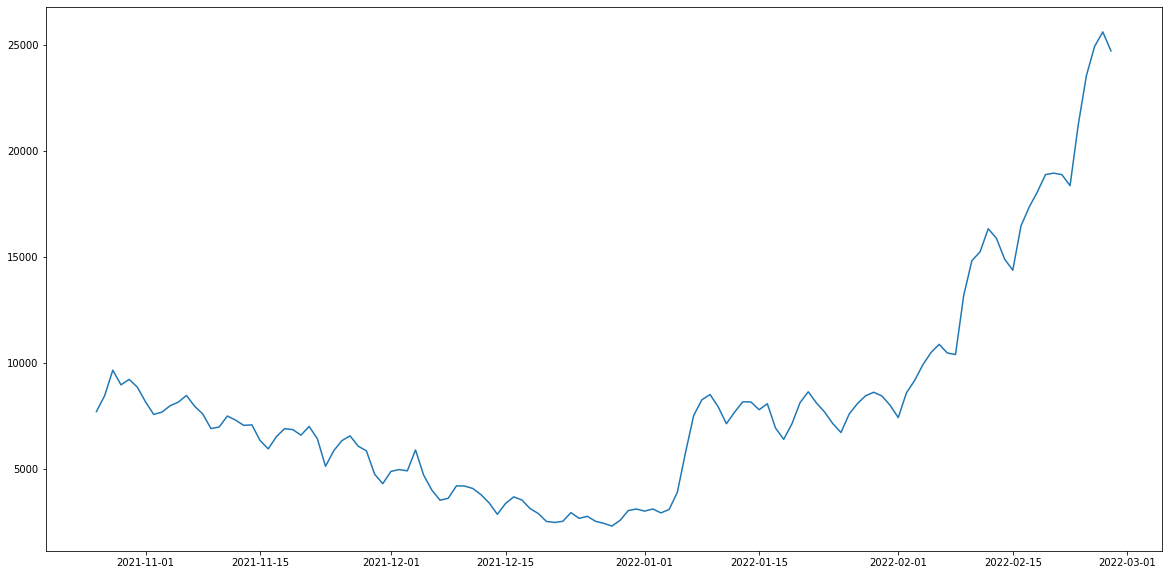

In [ ]:
plt.plot(cv_cases1["count"])

**ในส่วนของวิชา AI**

Prediction การพยากรณ์

นำข้อมูลจำนวนผู้ติดเชื้อโควิดในแต่ละวันมาวิเคราะห์

สร้าง DataFrame

In [ ]:
df = cv_cases1.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=['date','count'])
for i in range(0,len(data)):
    data["date"][i]=df['date'][i]
    data["count"][i]=df["count"][i]
data.head(125)

,date,count
0,2021-10-26 00:00:00,7706
1,2021-10-27 00:00:00,8452
2,2021-10-28 00:00:00,9658
3,2021-10-29 00:00:00,8968
4,2021-10-30 00:00:00,9224
...,...,...
120,2022-02-23 00:00:00,21232
121,2022-02-24 00:00:00,23557
122,2022-02-25 00:00:00,24932
123,2022-02-26 00:00:00,25615


Min-Max Scaler

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
data.index = data.date
data.drop("date",axis=1,inplace=True)
final_data = data.values
train_data = final_data[0:100,:] #ข้อมูลทดสอบ
valid_data = final_data[100:,:] #ข้อมูลที่ใช้
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    lstm_model = Sequential()

LSTM Model

In [ ]:
lstm_model.add(LSTM(units = 50, return_sequences=True, input_shape = (np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dense(1))

model_data = data[len(data)-len(valid_data)-60:].values
model_data = model_data.reshape(-1,1)
model_data = scaler.transform(model_data)

Train and Test Data ข้อมูลการทดสอบ

In [ ]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

40/40 - 4s - loss: 0.0085 - 4s/epoch - 98ms/step


Prediction Function ฟังก์ชั่นการทำนาย

In [ ]:
predicted_covid=lstm_model.predict(X_test)
predicted_covid=scaler.inverse_transform(predicted_covid)

1/1 [==============================] - 1s 767ms/step


Prediction Result ผลการทำนาย

จากข้อมูล 125 วัน  ทดสอบ 25 วัน วันที่ 26-10-2021 ถึง 27-02-2022

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


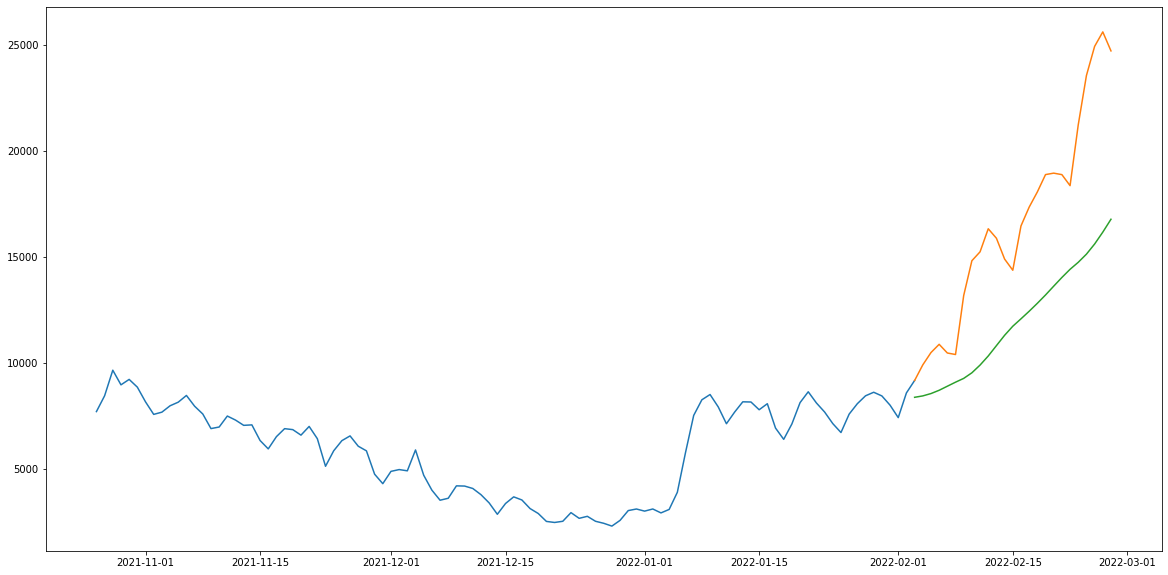

In [ ]:
train_data=data[:101]
valid_data=data[100:]
valid_data['Predictions']=predicted_covid
plt.plot(train_data["count"])
plt.plot(valid_data[['count',"Predictions"]])

****หมายเหตุ****

สีส้ม : เหตุการณ์จริง

สีเขียว : การคาดการณ์